In [1]:
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image

import os
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

#==========================================================================
# JUPYTER PATH STUFF. Not present in the main script coz does not affect it
# =========================================================================

os.chdir("..")


root = Path().resolve()
while root != root.parent:
    if (root / "scripts").is_dir():
        sys.path.insert(0, str(root))
        print("Added to sys.path:", root)
        break
    root = root.parent
else:
    raise RuntimeError("Could not find 'scripts' directory above this notebook")

from scripts.src import (
    build_model_and_tokenizer,
    get_image_transform,
    get_label_text_embeddings,
)

Added to sys.path: /home/woody/iwi5/iwi5362h/ALBEF


In [2]:
from scripts.albef_gradcam import (
    register_vit_gradcam_hooks,
    remove_vit_gradcam_hooks,
    generate_albef_gradcam,
    upsample_cam,
)

In [3]:
def infer_png_path(images_root: Path, image_id: str) -> Path:
    png_path = images_root / f"{image_id}.png"
    if not png_path.exists():
        raise FileNotFoundError(f"PNG not found for image_id={image_id}: {png_path}")
    return png_path

In [4]:
images_root = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/test")
output_dir = Path("/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_hooks")
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
config_path = "configs/Pretrain.yaml"
ckpt_path = "output_mimic_a40_transformations/checkpoint_29.pth"
device = "cuda"

In [6]:
torch.cuda.get_device_name(0)

'NVIDIA A40'

In [7]:
# Load model/tokenizer/config once and reuse
model, tokenizer, config, device = build_model_and_tokenizer(
    config_path=config_path,
    ckpt_path=ckpt_path,
    device=device,
)

image_res = config["image_res"]

[Model] Building ALBEF...
[Model] State dict loaded: <All keys matched successfully>


In [8]:
transform = get_image_transform(image_res)
model.eval()

# ---- Register Grad-CAM hooks ----
handles = register_vit_gradcam_hooks(model)
print("[Grad-CAM] Hooks registered.")

[Grad-CAM] Hooks registered.


In [9]:
# Load label CSV to get image_ids + label names
df = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/image_labels_test.csv")
id_col = df.columns[0]
all_label_cols = list(df.columns[1:])
print(f"[Data] Found {len(df)} rows, {len(all_label_cols)} labels")

[Data] Found 3000 rows, 28 labels


In [10]:
# For debugging a small batch
df = df.iloc[: 100].reset_index(drop=True)
print(f"[Data] Limiting to {len(df)} images (max_images=100)")

[Data] Limiting to 100 images (max_images=100)


In [11]:
df["__has_png__"] = df[id_col].apply(
    lambda x: (images_root / f"{x}.png").exists()
)
df = df[df["__has_png__"]].reset_index(drop=True)
print(f"[Data] After PNG filter: {len(df)} images")

image_ids = df[id_col].tolist()
label_cols = all_label_cols

[Data] After PNG filter: 100 images


In [12]:
# Precompute text embeddings for ALL labels in CSV ----
print("[Text] Computing label text embeddings...")
all_label_embs = get_label_text_embeddings(
    model=model,
    tokenizer=tokenizer,
    labels=all_label_cols,
    device=device,
    max_length=32,
)  # (L_all, D)
all_label_embs = F.normalize(all_label_embs, dim=-1)
print("[Text] Done.")

[Text] Computing label text embeddings...
[Text] Total prompts: 136 for 28 labels
[Text] Done.


In [13]:
# Map label name -> index into all_label_embs
label_to_idx = {lb: i for i, lb in enumerate(all_label_cols)}

In [14]:
# Prepare subset embedding tensor
subset_indices = [label_to_idx[lb] for lb in label_cols]
subset_embs = all_label_embs[subset_indices]  # (L_sub, D)

In [15]:
# ---- Process images ----
index_records = []

for idx_img, image_id in enumerate(image_ids, start=1):
    try:
        img_path = infer_png_path(images_root, image_id)
    except FileNotFoundError as e:
        print("[WARN]", e)
        continue

    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0)  # (1,3,H,W)

    heatmaps = {}
    for j, label in enumerate(label_cols):
        text_feat = subset_embs[j]  # (D,)

        cam_patch = generate_albef_gradcam(
            model=model,
            img_tensor=img_tensor,
            text_feat=text_feat,
            device=device,
            patch_grid=16,
        )  # (H', W')

        cam_up = upsample_cam(cam_patch, target_size=image_res)  # (H,W)
        heatmaps[label] = cam_up  # tensor

    out_path = output_dir / f"{image_id}.pt"
    heatmaps_cpu = {k: v.float().cpu() for k, v in heatmaps.items()}
    torch.save(heatmaps_cpu, out_path)
    index_records.append(
        {"image_id": image_id, "heatmap_path": str(out_path)}
    )

    if idx_img % 20 == 0 or idx_img == len(image_ids):
        print(f"[Grad-CAM] Processed {idx_img}/{len(image_ids)} images")

# ---- Remove hooks ----
remove_vit_gradcam_hooks(handles)
print("[Grad-CAM] Hooks removed.")

[Grad-CAM] Processed 20/100 images
[Grad-CAM] Processed 40/100 images
[Grad-CAM] Processed 60/100 images
[Grad-CAM] Processed 80/100 images
[Grad-CAM] Processed 100/100 images
[Grad-CAM] Hooks removed.


In [16]:
index_df = pd.DataFrame(index_records)
index_df.head()

,image_id,heatmap_path
0,e0dc2e79105ad93532484e956ef8a71a,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
1,0aed23e64ebdea798486056b4f174424,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
2,aa15cfcfca7605465ca0513902738b95,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
3,665c4a6d2693dc0286d65ab479c9b169,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
4,42da2c134b53cb5594774d3d29faac59,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...


In [17]:
img_path

PosixPath('/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/ca40cec6911dc19ae5a22ef7b474eea9.png')

In [18]:
# Visualization

def load_meta(meta_csv):
    """
    Load VinDr meta CSV with columns: image_id, dim0, dim1
    Returns dict: image_id -> (orig_height, orig_width)
    """
    df = pd.read_csv(meta_csv)
    return {r["image_id"]: (int(r["dim0"]), int(r["dim1"])) for _, r in df.iterrows()}


def visualize_heatmaps_and_gt_per_label(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    heatmaps_root: str,
    save_dir: str = None,   # << OPTIONAL
    alpha: float = 0.45,
    cmap: str = "jet",
    only_labels=None,
):
    """
    For a given VinDr image:
      - Plot heatmap + GT bounding box *per label instance* (one figure each).
      - Always SHOW the images.
      - SAVE ONLY if save_dir is provided.

    Produces:
      - If image has 5 GT boxes → shows 5 separate images.
      - If save_dir=None → only displays, does NOT save.
    """
    images_root = Path(images_root)
    heatmaps_root = Path(heatmaps_root)
    save_dir = Path(save_dir) if save_dir else None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)

    # ------------------ Load Annotations ------------------
    df_ann = pd.read_csv(annotations_csv)
    rows = df_ann[df_ann["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id}")

    if only_labels is not None:
        rows = rows[rows["class_name"].isin(only_labels)]
        if rows.empty:
            raise ValueError(f"No GT annotations for the requested labels: {only_labels}")

    # ------------------ Load Original Meta ------------------
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"{image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # ------------------ Load Image ------------------
    img_path = images_root / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Missing PNG: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size
    if w_png != 256 or h_png != 256:
        raise AssertionError(f"Expected 256x256 image, got {w_png}x{h_png}")

    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    # ------------------ Load Heatmaps ------------------
    hm_path = heatmaps_root / f"{image_id}.pt"
    if not hm_path.exists():
        raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

    heatmaps = torch.load(hm_path, map_location="cpu")
    heatmaps_np = {}
    for label, hm_tensor in heatmaps.items():
        hm = hm_tensor.float()
        # normalize 0–1
        if hm.max() > hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = torch.zeros_like(hm)
        heatmaps_np[label] = hm.detach().cpu().numpy()

    # ------------------ Iterate Over GT Boxes ------------------
    for idx, r in rows.iterrows():
        label = r["class_name"]

        if label not in heatmaps_np:
            print(f"[WARN] No heatmap for label '{label}' → skipping.")
            continue

        heatmap = heatmaps_np[label]

        # Resize heatmap if needed
        H_img, W_img = img.size[1], img.size[0]
        if heatmap.shape != (H_img, W_img):
            heatmap = np.array(
                Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
                    (W_img, H_img), resample=Image.BILINEAR
                )
            ) / 255.0

        # ------------------ Scale GT Box ------------------
        x_min = r["x_min"] * scale_x
        y_min = r["y_min"] * scale_y
        x_max = r["x_max"] * scale_x
        y_max = r["y_max"] * scale_y

        width = x_max - x_min
        height = y_max - y_min

        # ------------------ Create Visualization ------------------
        fig, ax = plt.subplots(figsize=(6, 6))

        ax.imshow(img)
        ax.imshow(heatmap, cmap=cmap, alpha=alpha)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x_min,
            max(y_min - 5, 0),
            label,
            fontsize=9,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none"),
        )

        ax.axis("off")
        ax.set_title(f"{image_id} — {label}")

        # SHOW ALWAYS
        plt.show()

        # SAVE OPTIONAL
        if save_dir is not None:
            out_name = f"{image_id}_{label.replace(' ', '_')}_{idx}.png"
            out_path = save_dir / out_name
            fig.savefig(out_path, bbox_inches="tight", pad_inches=0, dpi=150)
            print(f"[Saved] {out_path}")

        plt.close(fig)

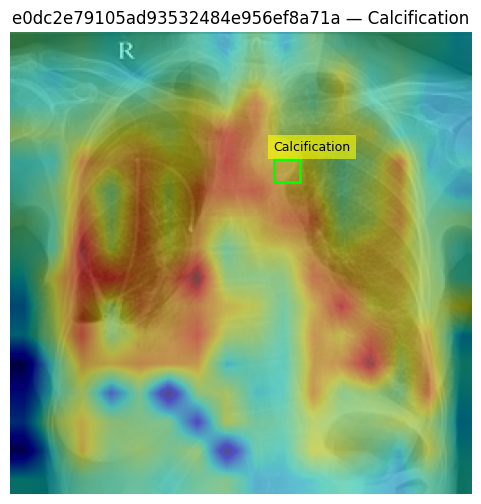

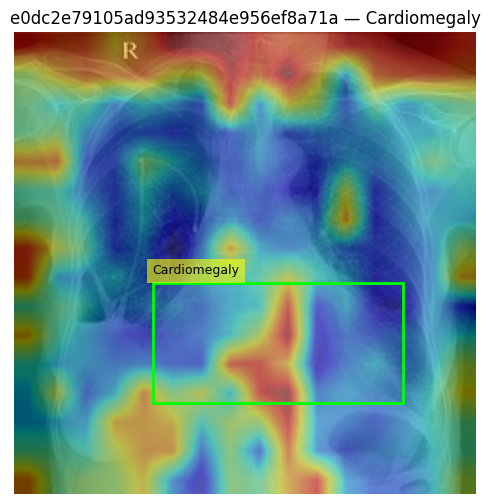

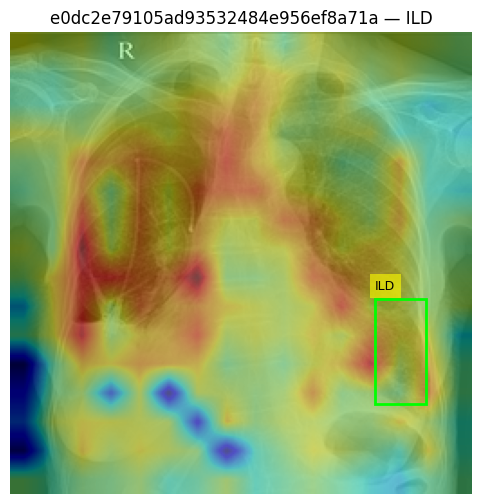

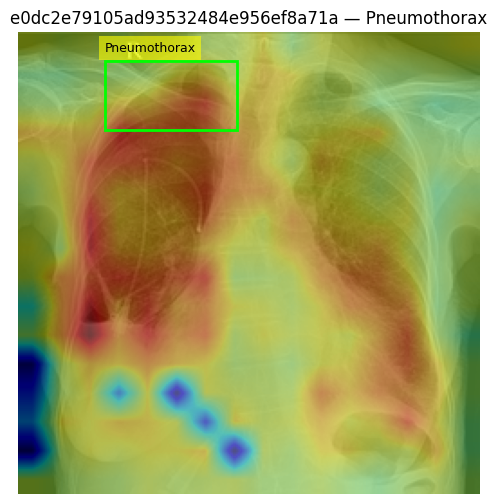

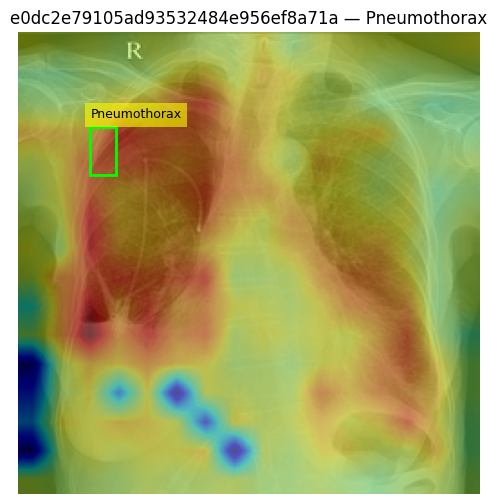

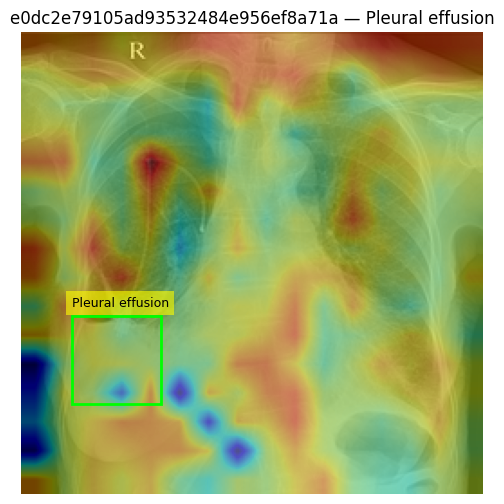

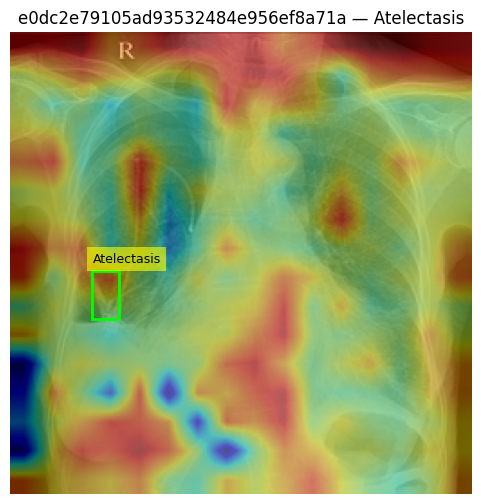

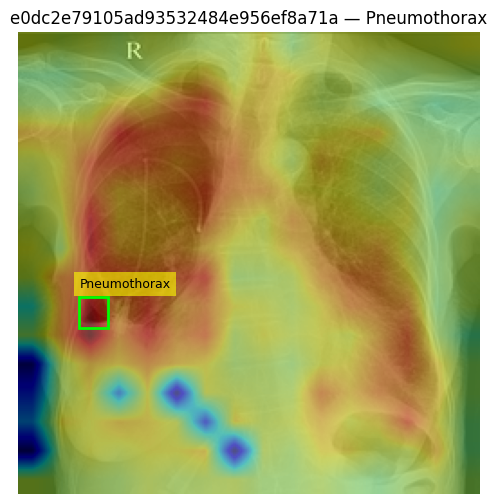

In [19]:
visualize_heatmaps_and_gt_per_label(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv="/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv",
    meta_csv="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv",
    heatmaps_root="/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_hooks",
)

In [27]:
image_id = "e0dc2e79105ad93532484e956ef8a71a"
heatmaps_root = "/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_hooks"
images_root = Path(images_root)
heatmaps_root = Path(heatmaps_root)
hm_path = heatmaps_root / f"{image_id}.pt"

In [28]:
if not hm_path.exists():
    raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

heatmaps = torch.load(hm_path, map_location="cpu")
heatmaps_np = {}
for label, hm_tensor in heatmaps.items():
    hm = hm_tensor.float()
    # normalize 0–1
    if hm.max() > hm.min():
        hm = (hm - hm.min()) / (hm.max() - hm.min())
    else:
        hm = torch.zeros_like(hm)
    heatmaps_np[label] = hm.detach().cpu().numpy()

In [41]:
for label, hm_tensor in heatmaps.items(): 
    print(np.nonzero(hm_tensor))

tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], size=(0, 2), dtype=torch.int64)
tensor([], 